# QPTUNA Tutorial

## Background
QPTUNA is a python package to automate the model building process for *REINVENT*. These models can use a variety of algorithms to fit to your input data and most of them have one or more so-called hyper-parameters (e.g. the maximum number of trees using a *Random Forest* or the C parameter in SVRs, controlling the influence of every support vector).

For both regression and classification tasks, QPTUNA allows you to specify input data for which the optimal hyper-parameters and a model can obtained automatically. If you want to get an idea on how the package is structured, read on otherwise you might want to skip it and  The following examples should give you an idea how.


### The three-step process

Optuna_AZ is structured around three steps:
1. **Hyperparameter Optimization:** 
    Train many models with different parameters using Optuna.
    Only the training dataset is used here. 
    Training is usually done with cross-validation.
2. **Build (Training):**
    Pick the best model from Optimization, 
    re-train it without cross-validation,
    and optionally evaluate its performance on the test dataset.
3. **Prod-build (or build merged):** 
    Re-train the best-performing model on the merged training and test datasets. 
    This step has a drawback that there is no data left to evaluate the resulting model, 
    but it has a big benefit that this final model is trained on the all available data.   

## Preparation

To use QPTUNA from Jupyter Notebook, install it with:
```
poetry build
python -m pip install dist/qptuna-2.4.2.tar.gz
```

## Regression example
This is a toy example of training a model that will predict molecular weight for a subset of DRD2 molecules. This example was chosen so that the whole run would take less than a minute.

Training dataset is a CSV file. It has SMILES strings in a column named "canonical". It has the value that we will try to predict in column "molwt".

This example has train and test (holdout) dataset ready. If you have single dataset and would like QPTUNA to split it into train and test (holdout) datasets, see the next section.

Here are a few lines from the input file:

In [1]:
!head  ../tests/data/DRD2/subset-50/train.csv

canonical,activity,molwt,molwt_gt_330
Cc1cc(NC(=O)c2cccc(COc3ccc(Br)cc3)c2)no1,0,387.233,True
O=C(Nc1ccc(F)cc1F)Nc1sccc1-c1nc2ccccc2s1,0,387.4360000000001,True
COC(=O)c1ccccc1NC(=O)c1cc([N+](=O)[O-])nn1Cc1ccccc1,0,380.36000000000007,True
CCOC(=O)C(C)Sc1nc(-c2ccccc2)ccc1C#N,0,312.39400000000006,False
CCC(CC)NC(=O)c1nn(Cc2ccccc2)c(=O)c2ccccc12,0,349.4340000000001,True
Brc1ccccc1OCCCOc1cccc2cccnc12,0,358.235,True
CCCCn1c(COc2cccc(OC)c2)nc2ccccc21,0,310.39700000000005,False
CCOc1cccc(NC(=O)c2sc3nc(-c4ccc(F)cc4)ccc3c2N)c1,0,407.4700000000001,True
COc1ccc(S(=O)(=O)N(CC(=O)Nc2ccc(C)cc2)c2ccc(C)cc2)cc1OC,0,454.54800000000023,True


### Create configuration

QPTUNA configuration can be read from a JSON file or created in Python. Here we create it in Python.

In [3]:
import sys
sys.path.append("..")

In [4]:
# Start with the imports.
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import (
    OptimizationConfig,
    SVR,
    RandomForestRegressor,
    Ridge,
    Lasso,
    PLSRegression,
    XGBRegressor,
)
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts

In [5]:
# Prepare hyperparameter optimization configuration.
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",  # Typical names are "SMILES" and "smiles".
        response_column="molwt",  # Often a specific name (like here), or just "activity".
        training_dataset_file="../tests/data/DRD2/subset-50/train.csv",
        test_dataset_file="../tests/data/DRD2/subset-50/test.csv"  # Hidden during optimization.
    ),
    descriptors=[
        ECFP.new(),
        ECFP_counts.new(),
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        XGBRegressor.new(),
        # PhyschemDescriptors.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,  # Total number of trials.
        n_startup_trials=50,  # Number of startup ("random") trials.
        direction=OptimizationDirection.MAXIMIZATION,
    ),
) 

### Run optimization

In [6]:
# Setup basic logging.
import logging
from importlib import reload
reload(logging)
logging.basicConfig(level=logging.INFO)

In [7]:
# Run Optuna Study.
study = optimize(config, study_name="my_study")
# Optuna will log it's progress to sys.stderr
# (usually rendered in red in Jupyter Notebooks).

[I 2021-11-03 15:27:23,002] A new study created in memory with name: my_study
[I 2021-11-03 15:27:24,256] Trial 0 finished with value: -0.02044806175686738 and parameters: {'algorithm_name': 'Ridge', 'alpha': 1.8048825129012993, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048}}'}. Best is trial 0 with value: -0.02044806175686738.
[I 2021-11-03 15:27:25,509] Trial 1 finished with value: 0.9079273253729204 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.3054683276243648, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 1 with value: 0.9079273253729204.
[I 2021-11-03 15:27:26,188] Trial 2 finished with value: -0.08624603482524736 and parameters: {'algorithm_name': 'PLSRegression', 'n_components': 2, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048}}'}. Best is trial 1 with value: 0.9079273253729204.
[I 2021-11-03 15:27:26,904] Trial 3 finished with value: 0.023

[I 2021-11-03 15:27:38,816] Trial 27 finished with value: -0.5210473145762867 and parameters: {'algorithm_name': 'RandomForestRegressor', 'max_depth': 16, 'n_estimators': 6, 'max_features': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048}}'}. Best is trial 23 with value: 0.9125014871557132.
[I 2021-11-03 15:27:39,011] Trial 28 finished with value: 0.8075332716546475 and parameters: {'algorithm_name': 'Ridge', 'alpha': 1.4978507147916165, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 23 with value: 0.9125014871557132.
[I 2021-11-03 15:27:39,240] Trial 29 finished with value: 0.2034737231588942 and parameters: {'algorithm_name': 'Ridge', 'alpha': 1.0204272325138264, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 23 with value: 0.9125014871557132.
[I 2021-11-03 15:27:40,149] Trial 30 finished with value: 0.16774199664230513 

[I 2021-11-03 15:27:46,119] Trial 53 finished with value: 0.9072122009642288 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.363403504852521, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 23 with value: 0.9125014871557132.
[I 2021-11-03 15:27:46,307] Trial 54 finished with value: 0.9080010205463492 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.2980337372814177, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 23 with value: 0.9125014871557132.
[I 2021-11-03 15:27:46,501] Trial 55 finished with value: 0.9085040243575623 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.2438422779548077, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 23 with value: 0.9125014871557132.
[I 2021-11-03 15:27:46,717] Trial 56 finished with value: 0.9103640412111674 and pa

[I 2021-11-03 15:27:51,504] Trial 79 finished with value: 0.9091851320743257 and parameters: {'algorithm_name': 'Lasso', 'alpha': 0.7092306751268378, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 77 with value: 0.9128972841755637.
[I 2021-11-03 15:27:51,724] Trial 80 finished with value: 0.9128961782931285 and parameters: {'algorithm_name': 'Lasso', 'alpha': 0.31348685376305047, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 77 with value: 0.9128972841755637.
[I 2021-11-03 15:27:51,918] Trial 81 finished with value: 0.9124846289536732 and parameters: {'algorithm_name': 'Lasso', 'alpha': 0.5004995288006024, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 77 with value: 0.9128972841755637.
[I 2021-11-03 15:27:52,120] Trial 82 finished with value: 0.9128753856650521 and 

### Visualize optimization progress

[Text(0.5, 0, 'Trial number'), Text(0, 0.5, 'Ojbective value')]

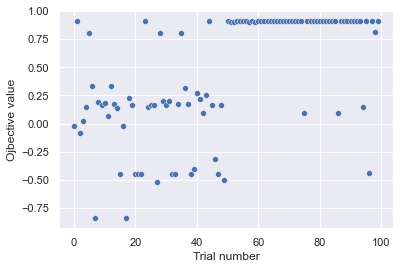

In [8]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.scatterplot(data=study.trials_dataframe(), x="number", y="value")
ax.set(xlabel="Trial number", ylabel="Ojbective value")

Sometimes it might be interesting to look at individual CV scores instead of aggregated score (mean CV score by default). Here we can plot all 3 cross validation scores (test_r2) for each trial.

[Text(0.5, 0, 'Trial number'), Text(0, 0.5, 'Ojbective value')]

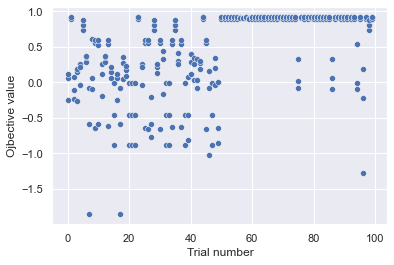

In [9]:
cv_test_r2 = study.trials_dataframe()["user_attrs_test_scores"].map(lambda d: d["test_r2"])
x = []
y = []
for i, vs in cv_test_r2.items():
    for v in vs:
        x.append(i)
        y.append(v)
ax = sns.scatterplot(x=x, y=y)
ax.set(xlabel="Trial number", ylabel="Ojbective value")

### Pick the best trial and build a model for it

We pick the best trial, inspect its configuration, build the best model, and save it as a pickled file.

In [11]:
# Get the best Trial from the Study and make a Build (Training) configuration for it.
buildconfig = buildconfig_best(study)

Optional: write out JSON of the best configuration.

In [12]:
import apischema
buildconfig_as_dict = apischema.serialize(buildconfig)

import json
print(json.dumps(buildconfig_as_dict, indent=2))

{
  "data": {
    "training_dataset_file": "../tests/data/DRD2/subset-50/train.csv",
    "input_column": "canonical",
    "response_column": "molwt",
    "test_dataset_file": "../tests/data/DRD2/subset-50/test.csv",
    "deduplication_strategy": {
      "name": "KeepAllNoDeduplication"
    },
    "split_strategy": {
      "name": "NoSplitting"
    },
    "save_intermediate_files": false,
    "intermediate_training_dataset_file": null
  },
  "metadata": {
    "cross_validation": 3,
    "shuffle": false,
    "best_trial": 91,
    "best_value": 0.9131011839501829,
    "n_trials": 100,
    "visualization": null
  },
  "descriptor": {
    "name": "ECFP_counts",
    "parameters": {
      "radius": 3,
      "useFeatures": true,
      "nBits": 2048
    }
  },
  "settings": {
    "mode": "regression",
    "direction": "maximize",
    "n_trials": 100
  },
  "algorithm": {
    "name": "Lasso",
    "parameters": {
      "alpha": 0.11179362980507357
    }
  },
  "task": "building"
}


Build (re-Train) and save the best model. This time training uses all training data, without splitting it into cross-validation folds.

In [13]:
buildconfig_best = build_best(buildconfig, "../target/best.pkl")

We can use the best (or merged) model as following

In [14]:
import pickle
with open("../target/best.pkl", "rb") as f:
    model = pickle.load(f)
model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([ 53.13534027, 174.21252922])

Now we can explore how good the best model performs on the test (holdout) set.

In [15]:
import pandas as pd

df = pd.read_csv(config.data.test_dataset_file)  # Load test data.

expected = df[config.data.response_column]
predicted = model.predict_from_smiles(df[config.data.input_column])

Text(0, 0.5, 'Predicted molwt')

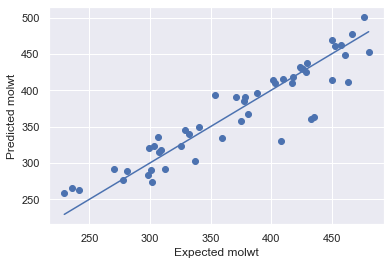

In [16]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
ax = plt.scatter(expected, predicted)
lims = [expected.min(), expected.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}")
plt.ylabel(f"Predicted {config.data.response_column}")

We can also calculate custom metrics for the best model:

In [17]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected, y_pred=predicted)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected, y_pred=predicted))  

# MAE
mae = mean_absolute_error(y_true=expected, y_pred=predicted)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.8563204537702751, RMSE: 26.23368678231321, Mean absolute error: 19.33448263201076


If the metrics look acceptable, the model is ready for use.

### Build merged model

Now we can merge train and test data, and build (train) the model again. We will have no more holdout data to evaluate the model, but hopefully the model will be a little better by seeing a little more data.

In [18]:
# Build (Train) and save the model on the merged train+test data.
build_merged(buildconfig, "../target/merged.pkl")

## Preprocessing: splitting data into train and test sets, and removing duplicates

### Splitting into train and test dataset

QPTUNA can split data into train and test (holdout) datasets. To do so, send all data in as training_dataset_file, and choose a splitting strategy. Currently QPTUNA supports three splitting strategies: random, temporal and stratified. 

Random strategy splits data randomly, taking a specified fraction of observations to be test dataset. 

Temporal strategy takes the first observations as training dataset, and the last specified fraction of observations as test dataset. The input dataset must be already sorted, from oldest in the beginning to newest and the end. This sorting can be done in any external tool (e.g. Excel). 

Stratified strategy splits data into bins first, and then takes a fraction from each bin to be the test dataset. This ensures that the distributions in the train and test data are similar. This is a better strategy if dataset is unballanced.

### Removing duplicates

All the algorithms QPTUNA supports do not work with duplicates. Duplicates can come from multiple measurements for the same compound, or from the fact that the molecular descriptors we use are all disregard stereochemistry, so even if compounds are different, descriptors make them into duplicates. QPTUNA provides several strategies to remove duplicates:
* keep first / keep last - when the first or the last measurement is the one that we trust
* keep max / keep min - when we want to keep the best value out of many
* keep random - when we don't want to know which one we will keep


### Configuration example

In [19]:
from optunaz.utils.preprocessing.splitter import Stratified
from optunaz.utils.preprocessing.deduplicator import KeepMax
# Prepare hyperparameter optimization configuration.
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-100/train.csv",  # This will be split into train and test.
        split_strategy=Stratified(fraction=0.2),
        deduplication_strategy=KeepMax(),
    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        XGBRegressor.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,
        n_startup_trials=50,
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
    ),
) 

In [20]:
study = optimize(config, study_name="my_study_stratified_split")

[I 2021-11-03 15:27:57,153] A new study created in memory with name: my_study_stratified_split
[I 2021-11-03 15:27:57,290] Trial 0 finished with value: 0.5272471400208008 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.8368250679799054, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 0 with value: 0.5272471400208008.
[I 2021-11-03 15:27:57,557] Trial 1 finished with value: 0.42250957333204076 and parameters: {'algorithm_name': 'RandomForestRegressor', 'max_depth': 5, 'n_estimators': 9, 'max_features': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 0 with value: 0.5272471400208008.
[I 2021-11-03 15:27:57,855] Trial 2 finished with value: 0.3777793264664564 and parameters: {'algorithm_name': 'RandomForestRegressor', 'max_depth': 13, 'n_estimators': 6, 'max_features': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", 

[I 2021-11-03 15:28:08,377] Trial 26 finished with value: 0.4329496723423098 and parameters: {'algorithm_name': 'RandomForestRegressor', 'max_depth': 28, 'n_estimators': 9, 'max_features': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 8 with value: 0.9030583677049787.
[I 2021-11-03 15:28:08,589] Trial 27 finished with value: 0.15782948858963275 and parameters: {'algorithm_name': 'PLSRegression', 'n_components': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048}}'}. Best is trial 8 with value: 0.9030583677049787.
[I 2021-11-03 15:28:08,993] Trial 28 finished with value: 0.40142259558029547 and parameters: {'algorithm_name': 'XGBRegressor', 'max_depth': 14, 'n_estimators': 106, 'learning_rate': 0.1, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 8 with value: 0.9030583677049787.
[I 2021-11-03 15:28:09,227] Trial 29 finished with value: 0.23910691043261814 and parameters

[I 2021-11-03 15:28:14,934] Trial 52 finished with value: 0.9022107553577784 and parameters: {'algorithm_name': 'Lasso', 'alpha': 0.9759177845094449, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 8 with value: 0.9030583677049787.
[I 2021-11-03 15:28:15,172] Trial 53 finished with value: 0.9021148058121113 and parameters: {'algorithm_name': 'Lasso', 'alpha': 0.9499765605487189, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 8 with value: 0.9030583677049787.
[I 2021-11-03 15:28:15,418] Trial 54 finished with value: 0.9027671497019458 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.086651864214256, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 8 with value: 0.9030583677049787.
[I 2021-11-03 15:28:15,646] Trial 55 finished with value: 0.9027120357202557 and param

[I 2021-11-03 15:28:21,695] Trial 78 finished with value: 0.9031232605647569 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.254400603917495, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 74 with value: 0.903154347852746.
[I 2021-11-03 15:28:21,949] Trial 79 finished with value: 0.902542668143119 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.0500240113469126, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 74 with value: 0.903154347852746.
[I 2021-11-03 15:28:22,173] Trial 80 finished with value: 0.9031359166611153 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.2449236367570193, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 74 with value: 0.903154347852746.
[I 2021-11-03 15:28:22,399] Trial 81 finished with value: 0.9031225253322783 and parame

/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:360: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  check_finite=False))
/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:360: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  check_finite=False))
/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:360: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  check_finite=False))
/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.72855397608553, tolerance: 18.69977074335155
  positive)
/Users/k

/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:360: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  check_finite=False))
/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:360: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  check_finite=False))
/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.65657648848655, tolerance: 18.69977074335155
  positive)
/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.886958102

## Choosing scoring function

By default, QPTUNA uses `r2` for regression and `roc_auc` for classification. It is possible to change to other scoring functions that are supported by scikit-learn (https://scikit-learn.org/stable/modules/model_evaluation.html):

In [23]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

This value can be set using `settings.scoring`:

In [26]:
config = OptimizationConfig(
    data=Dataset(
        input_column="canonical",
        response_column="molwt",
        training_dataset_file="../tests/data/DRD2/subset-100/train.csv",
    ),
    descriptors=[
        ECFP.new(), 
        ECFP_counts.new(), 
        MACCS_keys.new(),
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        XGBRegressor.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,
        n_startup_trials=50,
        scoring="neg_mean_squared_error",  # Scoring function name from scikit-learn.
        direction=OptimizationDirection.MAXIMIZATION,
        track_to_mlflow=False,
    ),
) 

In [27]:
study = optimize(config, study_name="my_study_rmse")

[I 2021-11-04 13:39:00,090] A new study created in memory with name: my_study_rmse
[I 2021-11-04 13:39:00,649] Trial 0 finished with value: -4522.32919205447 and parameters: {'algorithm_name': 'PLSRegression', 'n_components': 2, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 0 with value: -4522.32919205447.
[I 2021-11-04 13:39:01,374] Trial 1 finished with value: -715.4584859470755 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.8198822526980634, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 1 with value: -715.4584859470755.
[I 2021-11-04 13:39:01,503] Trial 2 finished with value: -695.3103946803325 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.3355890186137238, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 2 with value: -695.3103946803325.
[I 2021-1

[I 2021-11-04 13:39:17,734] Trial 25 finished with value: -6385.799403308432 and parameters: {'algorithm_name': 'SVR', 'gamma': 0.19945599853384313, 'C': 3.8943649528251663, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 2 with value: -695.3103946803325.
[I 2021-11-04 13:39:17,929] Trial 26 finished with value: -6380.0954347649395 and parameters: {'algorithm_name': 'SVR', 'gamma': 0.08622922160791371, 'C': 0.010977930771846108, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 2 with value: -695.3103946803325.
[I 2021-11-04 13:39:18,085] Trial 27 finished with value: -2802.907959386903 and parameters: {'algorithm_name': 'Lasso', 'alpha': 0.6017372034117843, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 2 with value: -695.3103946803325.
[I 2021-11-04 13:39:18,222] Trial 28 finished with value: -3569.689630365094 and p

[I 2021-11-04 13:39:22,141] Trial 51 finished with value: -714.9713628764683 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.808417232311313, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 2 with value: -695.3103946803325.
[I 2021-11-04 13:39:22,243] Trial 52 finished with value: -711.6786497352796 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.720804286950211, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 2 with value: -695.3103946803325.
[I 2021-11-04 13:39:22,338] Trial 53 finished with value: -707.3246591975536 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.5862284213403506, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 2 with value: -695.3103946803325.
[I 2021-11-04 13:39:22,432] Trial 54 finished with value: -705.014782642448 and paramet

[I 2021-11-04 13:39:24,912] Trial 77 finished with value: -686.0671553656374 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.0493091222333388, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 75 with value: -685.8500919441777.
[I 2021-11-04 13:39:25,033] Trial 78 finished with value: -686.0204826508867 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.052335798225665, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 75 with value: -685.8500919441777.
[I 2021-11-04 13:39:25,140] Trial 79 finished with value: -686.1391784934284 and parameters: {'algorithm_name': 'Lasso', 'alpha': 1.096321234130704, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 75 with value: -685.8500919441777.
[I 2021-11-04 13:39:25,249] Trial 80 finished with value: -685.9867982694376 and par

[Text(0.5, 0, 'Trial number'), Text(0, 0.5, 'Ojbective value')]

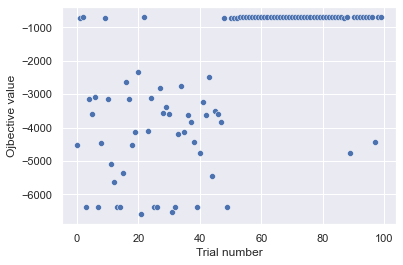

/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:360: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  check_finite=False))
/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:360: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  check_finite=False))
/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:360: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  check_finite=False))
/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:360: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  check_finite=False))
/Users/kfwm779/miniconda/envs/Optuna_AZ/lib/python3.7/site-packa

In [28]:
ax = sns.scatterplot(data=study.trials_dataframe(), x="number", y="value")
ax.set(xlabel="Trial number", ylabel="Ojbective value")